In [14]:
import netCDF4 as nc
import numpy as np
import pandas as pd

from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import plotly.express as px

# First, we pull in the data from farsite.nc
# this is all landfire data for santa clara county, california
ds = nc.Dataset('../data/farsite.nc')


# Simply printing data reveals some interesting ideas thoughts:
# There are the 14 bands described in our github repository, each with a CSV key. These are expected.
# However, there are three others:
# S1 albers_conical_equal_area(), float64 x(x), and float64 y(y)
#
#
# These are:
#
# S1 (single character string) telling us the projection type is "albers conical equal area"
#
# float64 x(x) x coordinates for this above projection
#
# float64 y(y) y coordinates for this above projection
ds

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    GDAL_AREA_OR_POINT: Area
    Conventions: CF-1.5
    GDAL: GDAL 3.3.2, released 2021/09/01
    history: Fri Feb  4 09:00:45 2022: ncrename -v Band14,US_SLP farsite.nc
Fri Feb  4 09:00:34 2022: ncrename -v Band13,US_FDIST farsite.nc
Fri Feb  4 09:00:20 2022: ncrename -v Band12,US_DEM farsite.nc
Fri Feb  4 09:00:00 2022: ncrename -v Band11,US_ASP farsite.nc
Fri Feb  4 08:59:47 2022: ncrename -v Band10,US_210FVT farsite.nc
Fri Feb  4 08:59:37 2022: ncrename -v Band9,US_210FVH farsite.nc
Fri Feb  4 08:59:27 2022: ncrename -v Band8,US_210FVC farsite.nc
Fri Feb  4 08:59:15 2022: ncrename -v Band7,US_210F40 farsite.nc
Fri Feb  4 08:59:04 2022: ncrename -v Band6,US_210EVH farsite.nc
Fri Feb  4 08:58:48 2022: ncrename -v Band5,US_210EVC farsite.nc
Fri Feb  4 08:58:38 2022: ncrename -v Band4,US_210CH farsite.nc
Fri Feb  4 08:58:19 2022: ncrename -v Band3,US_210CC farsite.nc
Fri Feb  4 08:58:07 20

In [15]:
# Let's examine this more closely

#
# First, basic shape and the bands

bands = ["US_210CBD", # Canopy Bulk Density (kg/m^3*100)
         "US_210CBH", # Canopy Base Height (m*10)
         "US_210CC",  # Canopy Cover (tree cover %)
         "US_210CH",  # Canopy Height (m*10)
         "US_210EVC", # Existing Vegetation Cover (Qualitative, see legend)
         "US_210EVH", # Existing Vegetation Height (Qualitative, see legend)
         "US_210F40", # Fuel Type Qualitative, see legend
         "US_210FVC", # Fuel Vegetation Cover (Qualitative, see legend)
         "US_210FVH", # Fuel Vegetation Height (Qualitative, see legend)
         "US_210FVT", # Fuel Vegetation Type (Qualitative, see legend)
         "US_ASP",    # Aspect (direction of slope face, in degrees from North)
         "US_DEM",    # Elevation (m)
         "US_FDIST",  # Fuel Disturbance (Qualitative, see legend)
         "US_SLP"]    # Slope (% change in elevation)


# Thankfully, every band has the same shape. We have our 30 meter X 30 meter grid
[ds[band].shape for band in bands]

[(2910, 3397),
 (2910, 3397),
 (2910, 3397),
 (2910, 3397),
 (2910, 3397),
 (2910, 3397),
 (2910, 3397),
 (2910, 3397),
 (2910, 3397),
 (2910, 3397),
 (2910, 3397),
 (2910, 3397),
 (2910, 3397),
 (2910, 3397)]

In [16]:
ds['x']

<class 'netCDF4._netCDF4.Variable'>
float64 x(x)
    standard_name: projection_x_coordinate
    long_name: x coordinate of projection
    units: m
unlimited dimensions: 
current shape = (3397,)
filling on, default _FillValue of 9.969209968386869e+36 used

In [17]:
ds['y']

<class 'netCDF4._netCDF4.Variable'>
float64 y(y)
    standard_name: projection_y_coordinate
    long_name: y coordinate of projection
    units: m
unlimited dimensions: 
current shape = (2910,)
filling on, default _FillValue of 9.969209968386869e+36 used

In [18]:
# From the above, two challenges should be clear:
# - Going back and forth from array indices to `x` and `y` coordinates in the "albers conical equal area" proj
# - Going back and forth from `x` and `y` coordinates in the albers projection to something we can plot on a map

# First, lets look at the projection
ds['albers_conical_equal_area']

<class 'netCDF4._netCDF4.Variable'>
|S1 albers_conical_equal_area()
    grid_mapping_name: albers_conical_equal_area
    false_easting: 0.0
    false_northing: 0.0
    latitude_of_projection_origin: 23.0
    longitude_of_central_meridian: -96.0
    standard_parallel: [29.5 45.5]
    long_name: CRS definition
    longitude_of_prime_meridian: 0.0
    semi_major_axis: 6378137.0
    inverse_flattening: 298.257222101004
    spatial_ref: PROJCS["USA_Contiguous_Albers_Equal_Area_Conic_USGS_version",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT[

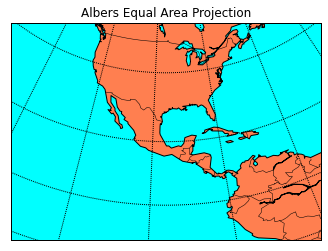

In [55]:
# Let's dive into the albers projection a little
#
# Albers Conical Equal Area is the projection style used by the US Geological Survey (hence LANDFIRE)
# It seeks to preserve area, but heavily distorts shape near the poles
#
# LANDFIRE gives us this: https://landfire.gov/faq.php?faq_id=274&sort_id=1
#
#   CONUS
#   Projection type: USA Contiguous Albers Equal Area Conic USGS Version (referenced as NAD_1983_CONUS_Albers (EPSG:5070))
#   Spheroid name: GRS 1980
#   Datum name: NAD83
#   Latitude of 1st parallel: 29.50 N               (1)
#   Latitude of 2nd parallel: 45.50 N               (2)
#   Longitude of central meridian: -96.00 W         (3)
#   Latitude of origin of projection: 23.00 N       (4)
#   False easting at central meridian: 0.0 meters
#   False northing at origin: 0.0 meters
#
# We see the info in lines 1,2,3,4 highlighted in the
#   `latitude_of_projection_origin`
#   `longitude_of_central_meridian`
#   `standard_parallel`
# properties of the albers band of `ds`

# Let's try to plot this (https://matplotlib.org/basemap/users/aea.html):

m = Basemap(width=10000000,height=7000000,
            resolution='c',projection='aea',\
            lat_1=29.5,lat_2=45.5,lon_0=-96.,lat_0=23.)
m.drawcoastlines()
m.drawcountries()
m.fillcontinents(color='coral',lake_color='aqua')
m.drawparallels(np.arange(-80.,81.,20.))
m.drawmeridians(np.arange(-180.,181.,20.))
m.drawmapboundary(fill_color='aqua')
plt.title("Albers Equal Area Projection")
plt.show()

In [82]:
# Let's try to convert the albers coordinates we have to latitude and longitude coordinates
#
# we can use our basemap from above to do this

def index2coordinates(i,j):
    """
    :param i: row index in netCDF
    :param j: col index in netCDF
    :return : (x albers, y albers)
    """
    if i < ds['x'].shape[0] and j < ds['y'].shape[0]:
        return (ds['x'][i].data, ds['y'][j].data)
    
def coordinate2latlon(x,y):
    """
    equations: https://en.wikipedia.org/wiki/Albers_projection,
    and https://pubs.usgs.gov/pp/1395/report.pdf (page 101)
    :param x: x albers coordinate
    :param y: y albers coordinate
    :return : (longitude, latitude)
    
    TODO: Fix this?
    """
    phi_1, phi_2 = 29.5, 45.5
    phi_0 = 23.
    lambda_0 = -96.
    R = 6371000 # radius of earth in meters?
    n = .5*(np.sin(phi_1) + np.sin(phi_2))
    C = np.cos(phi_1)**2 + 2*n*np.sin(phi_1)
    rho_0 = (R/n)*(C-2*n*np.sin(phi_0))**.5
    rho = (x**2 + (rho_0-y)**2)**.5
    theta = np.arctan(x/(rho_0-y))
    return (lambda_0 + theta/n, np.arcsin((C-(rho*n/R)**2)/(2*n)))

x, y = index2coordinates(500, 500)
x, y = coordinate2latlon(x,y)

# Let's test this by plotting. It should be somewhere in Santa Clara County.
# We need a dataframe, I believe. Get ready for a seriously lackluster, one item dataframe.
test = pd.DataFrame({'test':[100], 'lon': [x], 'lat': [y]})
print(test)
fig = px.scatter_mapbox(test, lat="lat", lon="lon",
                        color_discrete_sequence=["fuchsia"], zoom=1, height=300)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

   test        lon       lat
0   100 -97.106355 -0.853417
